In [84]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import datasets

%matplotlib inline

### Linear Regression

$$ life\_satisfaction = \theta _{0} + \theta _{1} \times GDP\_per\_capita $$

$$ \widehat{y} = \theta _{0} + \theta _{1}x_{1} + \theta _{2}x_{2} + ... +  \theta _{n}x_{n} $$

$$ \widehat{y} = h_{\mathbf{\theta }}\left ( \mathbf{x} \right ) = \mathbf{\theta }\cdot \mathbf{x} $$

$$ \mathrm{MSE}(\mathbf{X}, h_{\mathrm{\theta}}) = \frac{1}{m}\sum_{i = 1}^{m}(\mathbf{\theta}^{\top } x^{(i)} - y^{(i)})^{2} $$

### The Normal Equation

$$ \widehat{\theta} = (X^{\top}X)^{-1} X^{\top} y $$

In [77]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [5]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

In [8]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [9]:
theta_best

array([[3.97280799],
       [2.94890074]])

In [10]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.97280799],
       [9.87060946]])

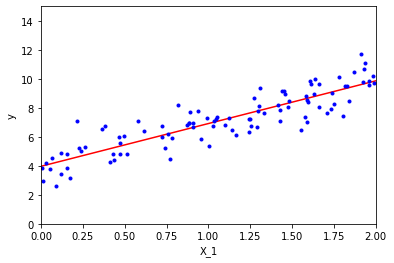

In [14]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.xlabel('X_1')
plt.ylabel('y')
plt.show()

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.97280799]), array([[2.94890074]]))

In [19]:
lin_reg.predict(X_new)

array([[3.97280799],
       [9.87060946]])

In [20]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.97280799],
       [2.94890074]])

In [21]:
np.linalg.pinv(X_b).dot(y)

array([[3.97280799],
       [2.94890074]])

### Batch Gradient Descent

$$ \frac{\partial }{\partial \theta_{j}}\mathrm{MSE(\theta)} = \frac{2}{m}\sum_{i = 1}^{m}(\theta^{\top}x^{(i)} - y^{(i)})x_{j}^{(i)} $$

$$ \nabla_{\theta}\mathrm{\theta} = \begin{pmatrix}
\frac{\partial }{\partial \theta_{0}}\mathrm{MSE}(\theta)\\ 
\frac{\partial }{\partial \theta_{1}}\mathrm{MSE}(\theta)\\ 
\vdots \\ 
\frac{\partial }{\partial \theta_{n}}\mathrm{MSE}(\theta)
\end{pmatrix} = \frac{2}{m}X^{\top}(X\theta - y) $$

$$ \theta^{(next step)} = \theta - \eta \nabla_{\theta}\mathrm{MSE}(\theta) $$

In [22]:
eta = 0.1
n_iterations = 1000
m = 100

In [23]:
theta = np.random.randn(2, 1) # random initialisation

In [25]:
for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [26]:
theta

array([[3.97280799],
       [2.94890074]])

### Stochastic Gradient Descent

In [27]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

In [28]:
def learning_schedule(t):
    return t0 / (t + t1)

In [29]:
theta = np.random.randn(2, 1)

In [31]:
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [32]:
theta

array([[3.96677097],
       [2.96297088]])

In [34]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [37]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.00307919]), array([3.00382583]))

### Polynomial Regression

In [46]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

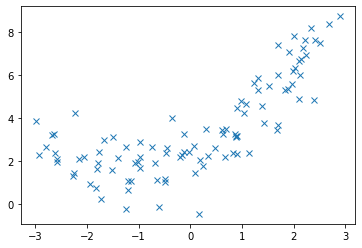

In [48]:
plt.plot(X, y, 'x')
plt.show()

In [50]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [51]:
X[0]

array([0.30562178])

In [52]:
X_poly[0]

array([0.30562178, 0.09340467])

In [53]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.2272149]), array([[1.04989665, 0.44844876]]))

### Learning Curves

In [56]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')

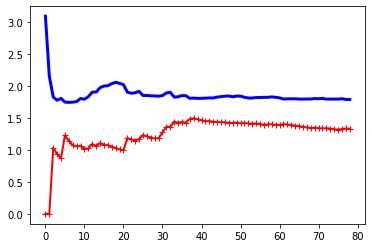

In [57]:
plot_learning_curves(lin_reg, X, y)

In [59]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

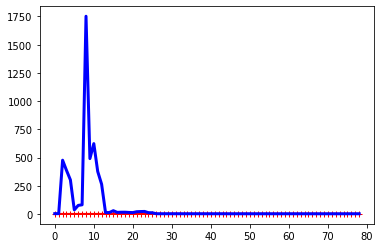

In [60]:
plot_learning_curves(polynomial_regression, X, y)

### Ridge Regression

$$ J(\theta) = \mathrm{MSE}(\theta) + \alpha\frac{1}{2}\sum_{i = 1}^{n} \theta_{i}^{2} $$

$$ \widehat{\theta} = (X^{\top}X + \alpha A)^{-1} X^{\top} y $$

In [62]:
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.88395278]])

In [63]:
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.85912014])

### Lasso Regression

$$ J(\theta) = \mathrm{MSE}(\theta) + \alpha\frac{1}{2}\sum_{i = 1}^{n} |\theta_{i}| $$

$$ g(\theta, J) = \nabla_{\theta}\mathrm{MSE}(\theta) + \alpha\begin{pmatrix}
\mathrm{sign}(\theta_{1})
\\\mathrm{sign}(\theta_{2}) 
\\ \vdots 
\\\mathrm{sign}(\theta_{n}) 
\end{pmatrix} \mathrm{where\ sign}(\theta_{i}) = \left\{\begin{matrix}
-1\ \mathrm{if}\ \theta_{i} < 0
\\0\ \mathrm{if}\ \theta_{i} = 0 
\\ +1\ \mathrm{if}\ \theta_{i} > 0
\end{matrix}\right. $$

In [65]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.8345533])

In [66]:
sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.85981966])

### Elastic Net

$$ J(\theta) = \mathrm{MSE}(\theta) + r \alpha\sum_{i = 1}^{n} |\theta_{i}| + \frac{1 - r}{2} \alpha \sum_{i = 1}^{n} \theta_{i}^{2}$$

In [69]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.83577884])

### Early Stopping

In [72]:
#prepare the data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

NameError: name 'X_train' is not defined

In [73]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, 
                       penalty=None, learning_rate='constant', eta0=0.0005)

In [74]:
minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

NameError: name 'X_train_poly_scaled' is not defined

### Estimating Probabilities

$$ \widehat{p} = h_{\theta}(x) = \sigma(x^{\top}\theta) $$

$$ \sigma (t) = \frac{1}{1 + \exp (-t)} $$

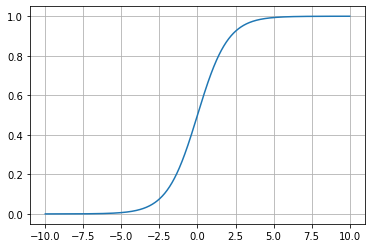

In [80]:
xp = np.linspace(-10, 10, 1000)
yp = 1 / (1 + np.exp(-xp))
plt.plot(xp, yp)
plt.grid()
plt.show()

$$ \widehat{y} = \left\{\begin{matrix}
0\ \mathrm{if}\ \widehat{p} < 0.5
\\ 1\ \mathrm{if}\ \widehat{p} \geq  0.5
\end{matrix}\right. $$

### Training and Cost Function

$$ c(\theta) = \left\{\begin{matrix}
-\log{(\widehat{p})}\ \mathrm{if}\ y = 1
\\-\log{(1 - \widehat{p})}\ \mathrm{if}\ y = 0
\end{matrix}\right. $$

$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(\widehat{p}^{(i)}) + (1 - y^{(i)})log(1 - \widehat{p}^{(i)})] $$


$$ \frac{\partial }{\partial \theta_{j}}\mathrm{J(\theta)} = \frac{1}{m}\sum_{i = 1}^{m}(\sigma(\theta^{\top}x^{(i)}) - y^{(i)})x_{j}^{(i)} $$

### Decision Boundaries

In [82]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [86]:
X = iris['data'][:, 3:] # petal width
y = (iris['target'] == 2).astype(int) # 1 if Iris virginica else 0

In [87]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

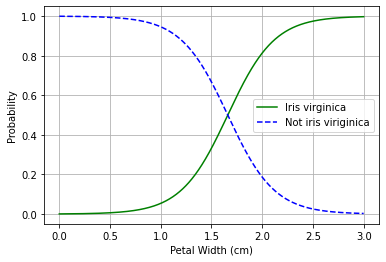

In [89]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not iris viriginica')
plt.legend()
plt.grid()
plt.xlabel('Petal Width (cm)'); plt.ylabel('Probability')
plt.show()

In [90]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### Softmax Regression

$$ s_{k}(\mathbf{x}) = \mathbf{x}^{\top}\theta^{(k)} $$

$$ \widehat{p}_{k} = \sigma(\mathbf{s}(\mathbf{x}))_{k} = \frac{\exp(s_{k}(\mathbf{x}))}{\sum_{j = 1}^{K}\exp(s_{j}(\mathbf{x}))} $$

$$ \widehat{y} = \underset{k}{\mathrm{argmax}}\ \sigma(\mathbf{s}(\mathbf{x}))_{k} = \underset{k}{\mathrm{argmax}}\ s_{k}(\mathbf{x}) = \underset{k}{\mathrm{argmax}}\ ((\theta^{(k)})^{\top}\mathbf{x}) $$

$$ J(\Theta) = -\frac{1}{m}\sum_{i = 1}^{m}\sum_{k = 1}^{K}y_{k}^{(i)}\log(\widehat{p}_{k}^{(i)}) $$

$$ \nabla_{\theta^{(k)}}J(\Theta) = \frac{1}{m}\sum_{i = 1}^{m}(\widehat{p}_{k}^{(i)} - y_{k}^{(i)})\mathbf{x}^{(i)} $$

In [91]:
X = iris['data'][:, (2, 3)] # petal length, petal width
y = iris['target']

In [93]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [94]:
softmax_reg.predict([[5, 2]])

array([2])

In [95]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

In [100]:
a = np.random.randn(5, 3)

In [114]:
alpha = 0.1
n_outputs = 3

In [116]:
np.r_[np.zeros([1, n_outputs]), alpha * a[1:]]

array([[ 0.        ,  0.        ,  0.        ],
       [-0.01438568,  0.20978939,  0.00785479],
       [ 0.0949321 , -0.1132431 , -0.09129873],
       [ 0.0418884 , -0.10148598,  0.1788978 ],
       [-0.08658735,  0.07176174,  0.04204228]])

In [102]:
np.sum(a, axis=1)

array([ 2.54160644,  2.03258508, -1.09609736,  1.19300219,  0.27216667])

In [103]:
np.sum(a, axis=1, keepdims=True)

array([[ 2.54160644],
       [ 2.03258508],
       [-1.09609736],
       [ 1.19300219],
       [ 0.27216667]])

In [109]:
a.shape

(5, 3)

In [110]:
a[1:].shape

(4, 3)

In [107]:
np.square(a[1:])

array([[0.02069476, 4.40115897, 0.00616977],
       [0.90121028, 1.28239996, 0.83354585],
       [0.1754638 , 1.02994033, 3.20044212],
       [0.74973696, 0.51497473, 0.17675533]])